# Etape 4: implémentation d'un DDQN

Dans cette partie nous allons entrainer un agent DQN et un agent QQGN sur l'environnement highway-fast-v0 et comparer leurs performances

### Imports et configurations

In [1]:
import pickle
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from collections import deque
import highway_env
from gymnasium.wrappers import FlattenObservation, RecordEpisodeStatistics

In [2]:
# Charger la configuration
with open("../config_part1.pkl", "rb") as f:
    config = pickle.load(f)

def make_env(render_mode='rgb_array'):
    env = gym.make("highway-fast-v0", config=config, render_mode=render_mode)
    env = FlattenObservation(env)
    env = RecordEpisodeStatistics(env)
    return env

# Set seeds
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

In [4]:
### Q-Network

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


### Définition des agents

Définition des agents. Deux modes possibles: 'dqn' et 'ddqn'

In [5]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, mode="dqn"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer(100000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.mode = mode

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.policy_net.fc[-1].out_features)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            return self.policy_net(state).argmax().item()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.policy_net(states).gather(1, actions)

        if self.mode == "dqn":
            next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        elif self.mode == "ddqn":
            next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
            next_q_values = self.target_net(next_states).gather(1, next_actions)

        expected_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        loss = nn.MSELoss()(q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [6]:
# Entraîner un agent
def train(agent, n_episodes=300):
    env = make_env()
    rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.update()

            state = next_state
            total_reward += reward

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        agent.update_target()
        rewards.append(total_reward)

        if (episode+1) % 10 == 0:
            print(f"Episode {episode+1}, Total Reward: {total_reward:.2f}")

    env.close()
    return rewards

In [7]:
# MAIN
env = make_env()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.close()

# Entraîner DQN
print("Training DQN...")
agent_dqn = DQNAgent(state_dim, action_dim, mode="dqn")
rewards_dqn = train(agent_dqn, n_episodes=500)

# Entraîner DDQN
print("Training DDQN...")
agent_ddqn = DQNAgent(state_dim, action_dim, mode="ddqn")
rewards_ddqn = train(agent_ddqn, n_episodes=500)

Training DQN...
Episode 10, Total Reward: 7.53
Episode 20, Total Reward: 11.39
Episode 30, Total Reward: 10.43
Episode 40, Total Reward: 11.59
Episode 50, Total Reward: 2.15
Episode 60, Total Reward: 3.68
Episode 70, Total Reward: 36.98
Episode 80, Total Reward: 4.46
Episode 90, Total Reward: 4.76
Episode 100, Total Reward: 7.38
Episode 110, Total Reward: 38.18
Episode 120, Total Reward: 45.15
Episode 130, Total Reward: 33.14
Episode 140, Total Reward: 13.19
Episode 150, Total Reward: 45.17
Episode 160, Total Reward: 50.48
Episode 170, Total Reward: 54.40
Episode 180, Total Reward: 49.13
Episode 190, Total Reward: 3.55
Episode 200, Total Reward: 3.18
Episode 210, Total Reward: 46.86
Episode 220, Total Reward: 51.35
Episode 230, Total Reward: 21.61
Episode 240, Total Reward: 8.93
Episode 250, Total Reward: 46.91
Episode 260, Total Reward: 39.19
Episode 270, Total Reward: 23.87
Episode 280, Total Reward: 47.73
Episode 290, Total Reward: 15.79
Episode 300, Total Reward: 50.14
Episode 310,

In [10]:
def moving_average(values, window_size):
    values = np.array(values)
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')

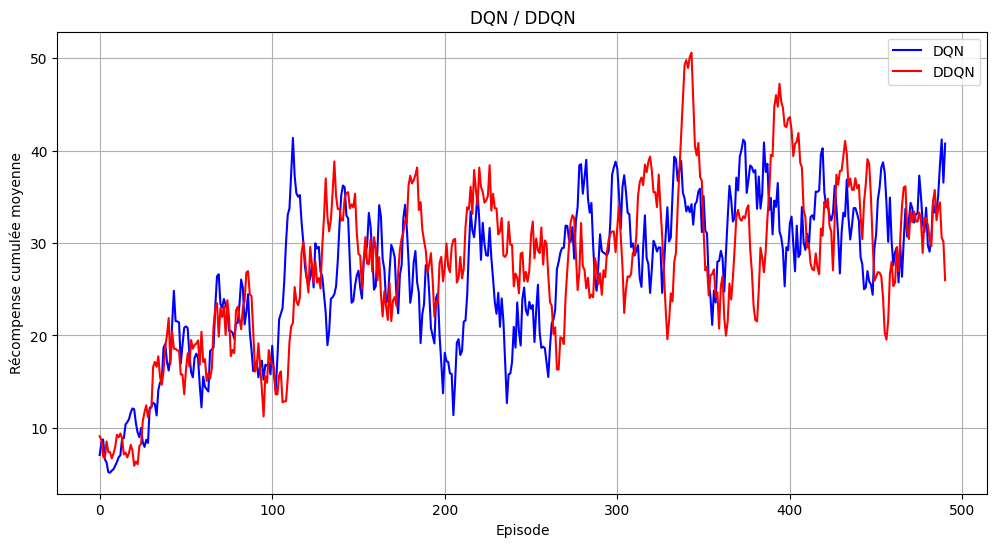

In [17]:
# Plot comparaison
plt.figure(figsize=(12, 6))
plt.plot(moving_average(rewards_dqn, 10), label='DQN', color='blue')
plt.plot(moving_average(rewards_ddqn, 10), label='DDQN', color='red')
plt.legend()
plt.ylabel('Récompense cumulée moyenne')
plt.title('DQN / DDQN')
plt.xlabel('Episode')
plt.grid()
plt.show()